# Advanced Machine Learning - Project 2
## Caenorhabditis elegans roundworms exploration

The purpose of this project is to understand if we can accuractly classify a worm's genotype based on its movement, as well as understand if it is possible to predict it's future movement.

- Eduardo Carneiro - 62515
- Til Dietrich - 62928


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from scipy.stats import mode
from scipy import signal

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

# statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# general parameters
sns.set(style='whitegrid', palette='muted', context='paper')
random_state = 42


In [3]:
# defining some general functions for this notebook

# function to create a differences time series (taken from class notebook), default is first difference
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return np.array(diff)

In [4]:
# read data, split into X and y
df_train = pd.read_csv("../worms_trainset.csv")
y_train = df_train.iloc[:,0]
X_train = df_train.drop(columns=[ df_train.columns[0] ])

df_test = pd.read_csv("../worms_testset.csv")
y_test = df_test.iloc[:,0]
X_test = df_test.drop(columns=[ df_test.columns[0] ])

## Table of Content
### 1. Data exploration and transformations
### 2. Models
#### 2.1. Classification
##### 2.1.1 Classification Observations
#### 2.2. ARIMA
##### 2.2.1. Walk-forward validation
##### 2.2.2. Blocked CV with walk-forward validation

## 1. Data exploration

In [5]:
# check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((180, 900), (180,), (76, 900), (76,))

The dataset consists of 256 univariate time series with 900 observations (time points) each.
In total, there are 256 worm traces. These time series are split 70%/30% into train and test set with 180 and 76 observations, respectively.

In [6]:
# check for nulls
print("Nulls in train set: ", df_train.isnull().sum().sum())

Nulls in train set:  0


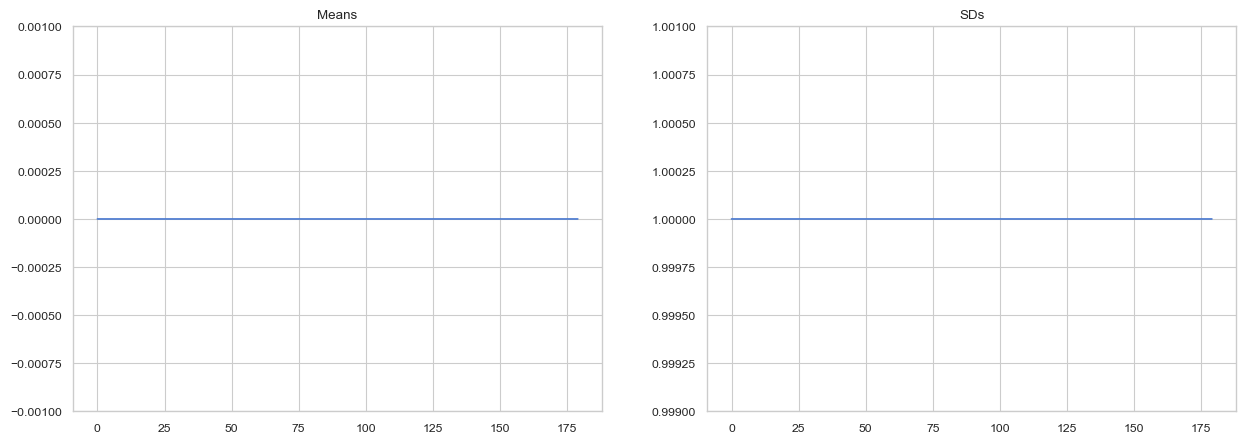

In [7]:
# normalize data if necessary
# calculate mean and std for each time series
means = X_train.mean(axis=1)
sds = X_train.std(axis=1)

# plot means and stds
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(means)
plt.title("Means")
plt.ylim(-0.001, 0.001)
plt.subplot(1,2,2)
plt.plot(sds)
plt.title("SDs")
plt.ylim(0.999, 1.001)
plt.show()

There is no need to normalize the data as they are already normalized to follow a normal distribution with 0 mean and a standard deviation of 1.

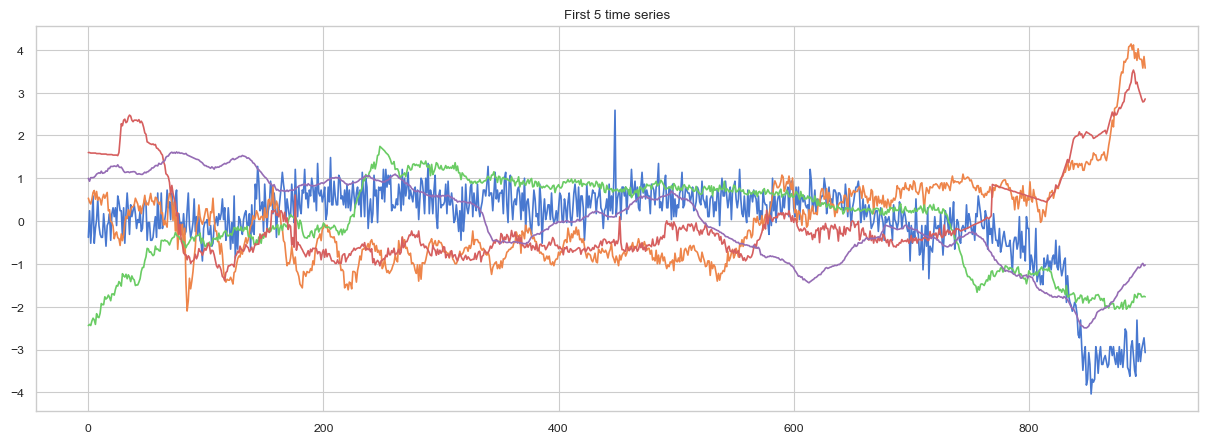

In [8]:
# plot first X time series in one graph
n_series = 5

plt.figure(figsize=(15,5))
for i in range(n_series):
    plt.plot( range(0,900),X_train.iloc[i,:])
plt.title("First 5 time series")
plt.show()


# Noise Removal
As it can be seen in the graph before, there is some noise in the data (outliers).

To smooth the data and try to mitigate this noise, we will use the moving average method.

In [9]:
# Moving-Average Smoothing
n = 900
window_size = 5

X_train_mov_avg = np.array([X_train.iloc[i,:].rolling(window_size).mean() for i in range( X_train.iloc[:n,:].shape[0] )])[:,window_size:]
X_test_mov_avg = np.array([X_test.iloc[i,:].rolling(window_size).mean() for i in range( X_test.iloc[:n,:].shape[0] )])[:,window_size:]

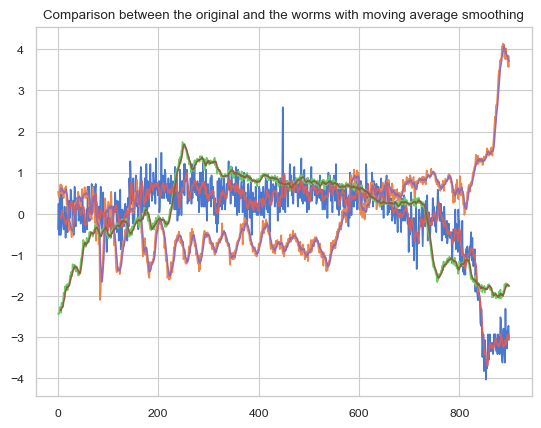

In [10]:
n_series = 3

plt.title("Comparison between the original and the worms with moving average smoothing")
for i in range(n_series):
    plt.plot( range(0, 900),X_train.iloc[i,:])

for i in range(n_series):
    plt.plot( range(window_size, 900), X_train_mov_avg[i] )
plt.show()


# Representation
In order to evalute if the representation of the data has an impact on the classification, we will try different representations and compare the results.
We decided in using the following representations:
- Original data
- Moving average
- PAA over Moving average
- SAX over Moving average
- Statistical Feature Space over Moving average
- DFT over Moving average (as the worms behave like waves, DFT might be a good representation given the fact that it gets the fundamental frequencies of the signal)

### PAA

In [11]:
n_seg = 550
paa = PiecewiseAggregateApproximation(n_segments= n_seg)

X_train_paa = paa.fit_transform( X_train_mov_avg ).reshape(180,n_seg)
# df_train_paa = pd.DataFrame(df_train_paa).dropna(axis=1)

X_test_paa = paa.fit_transform( X_test_mov_avg ).reshape(76,n_seg)
# df_test_paa = pd.DataFrame(df_test_paa).dropna(axis=1)

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 180 1-dimensional timeseries
  warnings.warn(
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


### Summarization Methods
- This is a really basic summarization method, but it might be useful to reduce the size of the dataset
- This representation could be further extend nad optimizedby including more features, like other statistical measures

In [12]:
ft_space_train = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in X_train_mov_avg ]
ft_space_test = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in X_test_mov_avg ]

### DFT

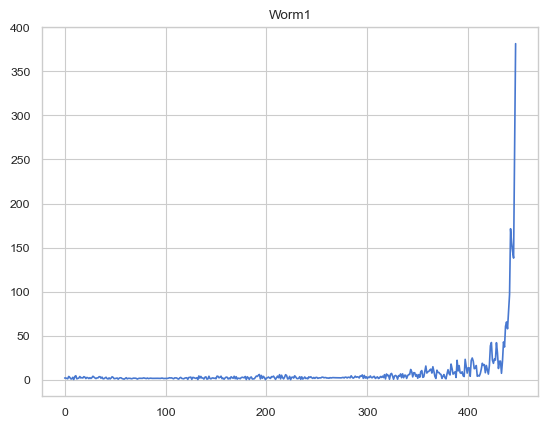

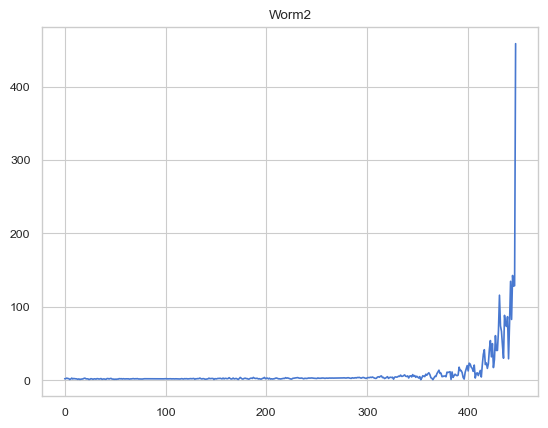

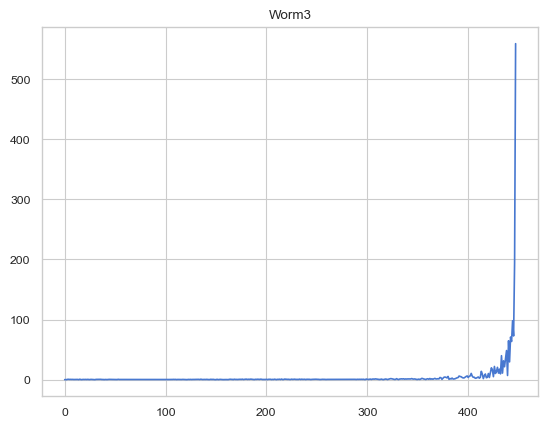

In [13]:
dfts_train = np.fft.fft(X_train_mov_avg)
dfts_test = np.fft.fft(X_test_mov_avg)

# Why this? Because the DFT returns complex values and KNN does not support complex values
# We convert a complex value into a tuple with the real and imaginary part as floats
dfts_train_fin = []
for worm in dfts_train:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_train_fin.append(temp)

dfts_test_fin = []
for worm in dfts_test:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_test_fin.append(temp)


half = int(len(dfts_train[0])/2)

# plot the dft
plt.title("Worm1")
plt.plot(abs(dfts_train[0][half:]))
plt.show()

# plot the dft
plt.title("Worm2")
plt.plot(abs(dfts_train[1][half:]))
plt.show()

# plot the dft
plt.title("Worm3")
plt.plot(abs(dfts_train[2][half:]))
plt.show()

## 2.1. Classification
In order to classify each worm trace, we tested multiple classifiers:
- KNN with different metrics (Euclidean, DTW)
- Random Forest Classifier
- Logistic Regression Classifier
- Hidden Markov Model (HMM)
- K-Means Clustering

In each classifier, we did some Grid Search to find the best hyper-parameters for each classifier, and also tested each of these classifiers with different data representations shown before.

## KNN
- Just some tests to see how the KNN performs on the original raw data with some metrics


In [14]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.6052631578947368
euclidean:knn3|0.5394736842105263
euclidean:knn5|0.5
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5526315789473685
dtw:knn1|0.618421052631579
dtw:knn3|0.5526315789473685
dtw:knn5|0.5394736842105263
dtw:knn7|0.5657894736842105
dtw:knn9|0.5921052631578947


- Observing KNN performance with smoothed data from moving average

In [15]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(X_train_mov_avg, y_train)

        y_pred = knn.predict(X_test_mov_avg)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.5789473684210527
euclidean:knn3|0.5263157894736842
euclidean:knn5|0.4868421052631579
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5394736842105263
dtw:knn1|0.618421052631579
dtw:knn3|0.618421052631579
dtw:knn5|0.5789473684210527
dtw:knn7|0.5526315789473685
dtw:knn9|0.618421052631579


- Observing KNN performance with PAA representation

In [16]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn_paa = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)
        knn_paa.fit( X_train_paa, y_train)

        y_pred = knn_paa.predict(X_test_paa)
        # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
        # This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
        print(f"PAA|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")



PAA|euclidean:knn1|acc:0.6578947368421053|f1:0.6561780796076211
PAA|euclidean:knn3|acc:0.631578947368421|f1:0.6206140350877193
PAA|euclidean:knn5|acc:0.6578947368421053|f1:0.6436726737478617
PAA|euclidean:knn7|acc:0.6710526315789473|f1:0.6551914377137814
PAA|euclidean:knn9|acc:0.6447368421052632|f1:0.6092465205567109
PAA|dtw:knn1|acc:0.618421052631579|f1:0.6191632928475034
PAA|dtw:knn3|acc:0.5526315789473685|f1:0.5542079299729239
PAA|dtw:knn5|acc:0.5789473684210527|f1:0.5768345595170722
PAA|dtw:knn7|acc:0.5657894736842105|f1:0.5590630485453656
PAA|dtw:knn9|acc:0.6052631578947368|f1:0.6032823995472553


- Observing KNN performance with SAX representation

In [17]:
for n_seg in [250, 350, 450, 550, 650]:
    for alph_size in [10, 20, 30, 40]:
        for neigh_num in [1,3,5]:
            knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= "sax", metric_params={"n_segments": n_seg, "alphabet_size_avg": alph_size})
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            print(f"SAX|knn{neigh_num}|n_seg:{n_seg}:alph_size:{alph_size}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

SAX|knn1|n_seg:250:alph_size:10|acc:0.6052631578947368|f1:0.6074745687748785
SAX|knn3|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn5|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn1|n_seg:250:alph_size:20|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:20|acc:0.5131578947368421|f1:0.5141048908744008
SAX|knn5|n_seg:250:alph_size:20|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:30|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:30|acc:0.5394736842105263|f1:0.5384059399434916
SAX|knn5|n_seg:250:alph_size:30|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:40|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:40|acc:0.5263157894736842|f1:0.5208237986270023
SAX|knn5|n_seg:250:alph_size:40|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:350:alph_size:10|acc:0.6052631578947368|f1:0.6066540558584622

- Observing KNN performance with summarization methods representation

In [18]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(ft_space_train, y_train)

        y_pred = knn.predict(ft_space_test)

        print(f"feature_space|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

feature_space|euclidean:knn1|acc:0.5657894736842105|f1:0.5504069451980467
feature_space|euclidean:knn3|acc:0.5394736842105263|f1:0.5323395969420543
feature_space|euclidean:knn5|acc:0.5921052631578947|f1:0.5887986043292341
feature_space|euclidean:knn7|acc:0.5263157894736842|f1:0.5208237986270023
feature_space|euclidean:knn9|acc:0.5526315789473685|f1:0.5393170426065164
feature_space|dtw:knn1|acc:0.5394736842105263|f1:0.5172680127992938
feature_space|dtw:knn3|acc:0.5657894736842105|f1:0.5551246537396122
feature_space|dtw:knn5|acc:0.5921052631578947|f1:0.5857865001486767
feature_space|dtw:knn7|acc:0.5131578947368421|f1:0.5056161453387432
feature_space|dtw:knn9|acc:0.5526315789473685|f1:0.5393170426065164


- Observing KNN performance with DFT representation

In [19]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(dfts_train_fin, y_train)

        y_pred = knn.predict(dfts_test_fin)
        print(f"DFT|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

DFT|euclidean:knn1|acc:0.5789473684210527|f1:0.5789473684210527
DFT|euclidean:knn3|acc:0.5263157894736842|f1:0.5169324632196779
DFT|euclidean:knn5|acc:0.4868421052631579|f1:0.48565233307989075
DFT|euclidean:knn7|acc:0.5131578947368421|f1:0.5012003693444137
DFT|euclidean:knn9|acc:0.5394736842105263|f1:0.5172680127992938
DFT|dtw:knn1|acc:0.5394736842105263|f1:0.5231588812706556
DFT|dtw:knn3|acc:0.5789473684210527|f1:0.5706066339730471
DFT|dtw:knn5|acc:0.631578947368421|f1:0.6242808047264162
DFT|dtw:knn7|acc:0.6447368421052632|f1:0.6392334033552991
DFT|dtw:knn9|acc:0.6578947368421053|f1:0.6477130325814535


## Random Forest

In [20]:
for tree_num in [100, 200, 250, 300]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        rfc = RandomForestClassifier(n_estimators=tree_num)

        if name == "dft": # random forest does not support array with arrays inside, so we decided to flatten the dft array here
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        rfc.fit(rep_train, y_train)
        y_pred = rfc.predict(rep_test)

        print(f"RFC|tree_num:{tree_num}|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

RFC|tree_num:100|mov_avg|acc:0.5789473684210527|f1:0.5789473684210527
RFC|tree_num:100|paa|acc:0.6052631578947368|f1:0.6052631578947368
RFC|tree_num:100|ft_space|acc:0.6578947368421053|f1:0.6539282990083906
RFC|tree_num:100|dft|acc:0.631578947368421|f1:0.6336429308565531
RFC|tree_num:200|mov_avg|acc:0.5789473684210527|f1:0.5664160401002507
RFC|tree_num:200|paa|acc:0.618421052631579|f1:0.6202301187560648
RFC|tree_num:200|ft_space|acc:0.6578947368421053|f1:0.6539282990083906
RFC|tree_num:200|dft|acc:0.631578947368421|f1:0.631578947368421
RFC|tree_num:250|mov_avg|acc:0.631578947368421|f1:0.627307398932113
RFC|tree_num:250|paa|acc:0.6052631578947368|f1:0.6052631578947368
RFC|tree_num:250|ft_space|acc:0.618421052631579|f1:0.6153277266305739
RFC|tree_num:250|dft|acc:0.6052631578947368|f1:0.6006864988558352
RFC|tree_num:300|mov_avg|acc:0.6052631578947368|f1:0.6006864988558352
RFC|tree_num:300|paa|acc:0.618421052631579|f1:0.6175363502388931
RFC|tree_num:300|ft_space|acc:0.6578947368421053|f1:0

## Logistic regression classifier

In [21]:
for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
    lrc = LogisticRegression(random_state=0, max_iter=2200)

    if name == "dft":
        rep_train = np.reshape(rep_train, (180,895*2))
        rep_test = np.reshape(rep_test, (76,895*2))

    lrc.fit(rep_train, y_train)
    y_pred = lrc.predict(rep_test)

    print(f"LRC|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

LRC|mov_avg|acc:0.5131578947368421|f1:0.5161331826160477
LRC|paa|acc:0.5131578947368421|f1:0.5154660135853241
LRC|ft_space|acc:0.5921052631578947|f1:0.4536474877032152
LRC|dft|acc:0.5789473684210527|f1:0.581588116633046


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## HMM

In [22]:
from hmmlearn import hmm


for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, ft_space_train, dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
   
    # Define the Hidden Markov Model

    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", random_state=8)

    if name == "dft":
        rep_train = np.reshape(rep_train, (180,895*2))
        rep_test = np.reshape(rep_test, (76,895*2))
    
    # Train the model on the data
    model.fit(rep_train)

    y_pred = model.predict(rep_test)

    print(f"HMM:{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

HMM:mov_avg|acc:0.17105263157894737|f1:0.15639097744360905
HMM:paa|acc:0.2236842105263158|f1:0.21366849960722697
HMM:ft_space|acc:0.40789473684210525|f1:0.24627606752730882
HMM:dft|acc:0.15789473684210525|f1:0.16040100250626566


## K-Means

In [23]:


for metric in ["euclidean","dtw" ]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, np.array(ft_space_train), dfts_train_fin], [X_test_mov_avg, X_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        km = TimeSeriesKMeans(n_clusters=2, metric=metric, random_state=0)
       
        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        y_pred = km.fit_predict(rep_train)
        print(silhouette_score(rep_train,y_pred,metric=metric))

        # print(f"LRC|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

0.1141667463659055
0.13318981934344137
0.6103879984483321
0.1141667463659055
0.16834789446443849
0.17161459061788706
0.5461129889991868
0.1523812402989934


"The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1" 
"The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."
(taken from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html))

Given this information, we can conclude that in most of representation, **K-Means** does **not perform very well**, as the Silhouette Score is close to 0, which means the **clusters are overlapping**.


In [24]:
# remove user warnings
# import warnings
# warnings.filterwarnings('ignore')

for metric in ["euclidean","dtw" ]:
    for rep_train, rep_test,name in zip([X_train_mov_avg, X_train_paa, np.array(ft_space_train), dfts_train_fin], [X_test_mov_avg, X_test_paa, np.array(ft_space_test), dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        km = TimeSeriesKMeans(n_clusters=2, metric=metric, random_state=0)
       
        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        y_pred = km.fit(rep_train).predict(rep_test)
        print(f"k-means:{metric}|acc:{accuracy_score(y_test,y_pred)}|sil_score:{silhouette_score(rep_test,y_pred,metric=metric)}")

k-means:euclidean|acc:0.25|sil_score:0.08906706674604518
k-means:euclidean|acc:0.17105263157894737|sil_score:0.11463678516025695
k-means:euclidean|acc:0.2631578947368421|sil_score:0.644654659245818


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


k-means:euclidean|acc:0.25|sil_score:0.08906706674604514


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


k-means:dtw|acc:0.18421052631578946|sil_score:0.12698432616145536


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


k-means:dtw|acc:0.21052631578947367|sil_score:0.13347747716411024


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


k-means:dtw|acc:0.18421052631578946|sil_score:0.5283129414403422


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


k-means:dtw|acc:0.13157894736842105|sil_score:0.11531556918314752


### 2.2.1 Classification Observations
After all the tests, we can conclude that the best classifier for this dataset is the **Random Forest Classifier** with the **DFT** representation.

As stated before, the worms behave like waves, so the DFT representation is a good representation to get the fundamental frequencies of the signal.

Nevertheless, the best accuracy is still only **68%**, which is, objectively, **not a very good** result.
This can be caused by several factors:
- The dataset is **too small** (only 256 samples, which have yet to be split into train and test set)
- The dataset is **too noisy** (applying moving average fixes some of the noise, but also removes some of the "unique" characteristics of each worm)
- The worms are **too different inside each class** or very similar between classes (this is a problem that we cannot solve, as we cannot change the dataset, and will be shown below)

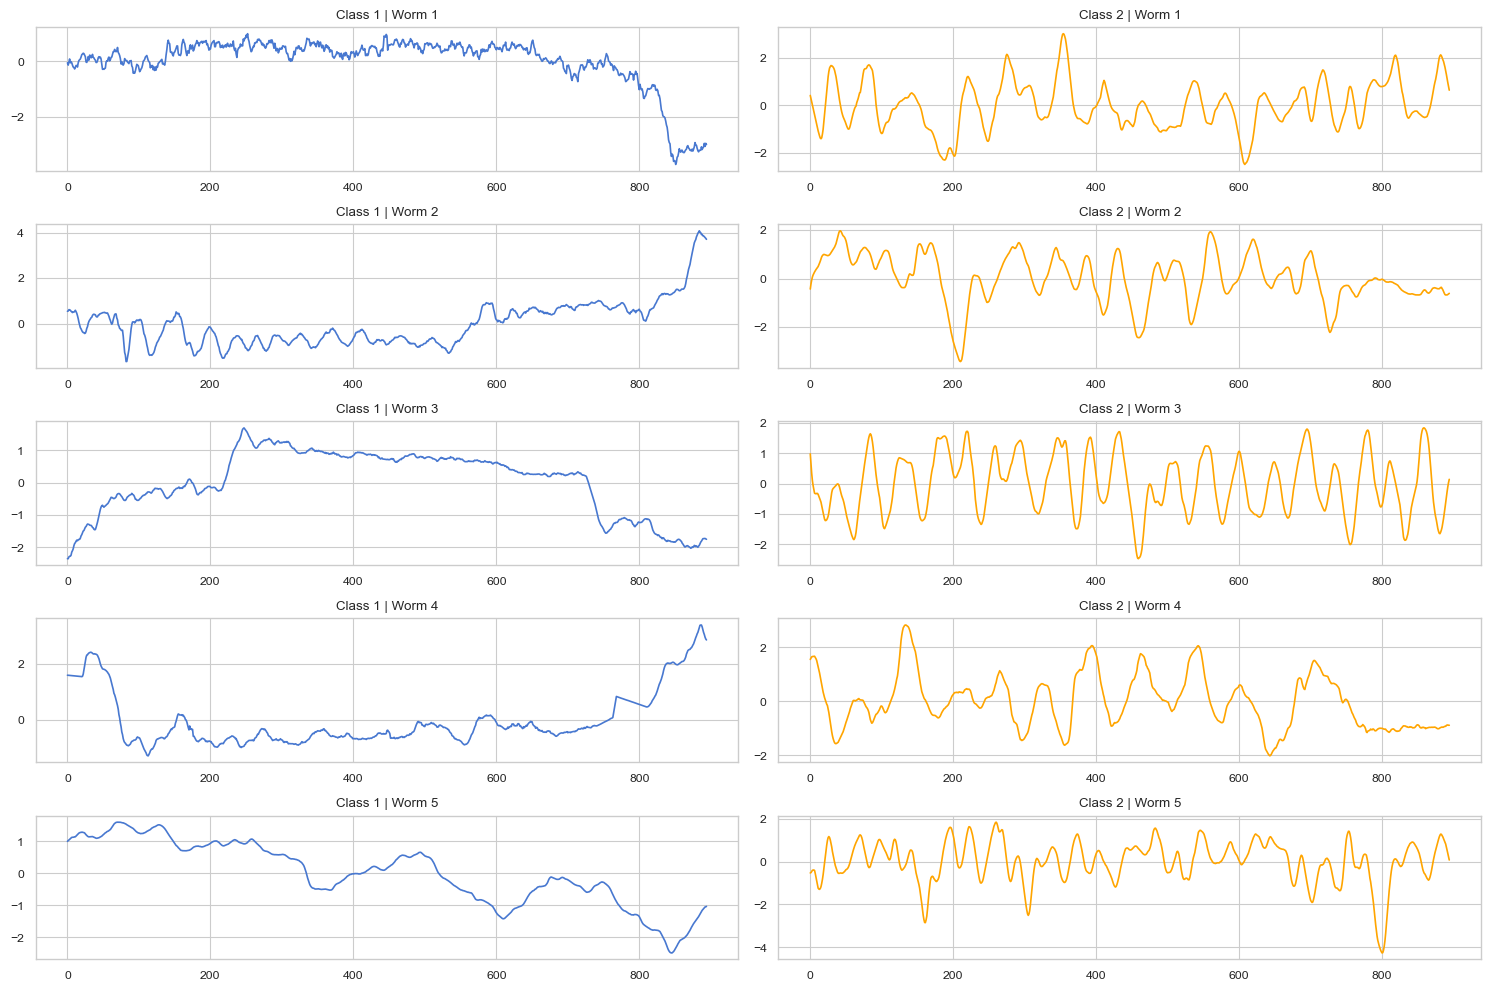

In [25]:
fig = plt.figure(figsize=(15,10))

# Class 1
for pl, it in zip(range(1,10,2), range(1,6)):
    # plt.figure(figsize=(15,5))
    plt.subplot(5,2,pl)
    plt.plot(X_train_mov_avg[it-1])
    plt.title(f"Class 1 | Worm {it}")    

# Class 2
for pl, it in zip(range(2,11,2),range(65,70)):
    plt.subplot(5,2,pl)
    plt.plot(X_train_mov_avg[it], color="orange")
    plt.title(f"Class 2 | Worm {it-64}")

fig.tight_layout()
plt.show()

Above are plots showcasing 5 worms from each class.

As it can be seen, the worms are **very different between each class**, that's notorious.

However, **inside each class, the worms are not very similar**, which makes it **hard to generalize** the worm for that class.
Thus, this affects the performance of classification, as the classifier **cannot fully perceive a general pattern** for each class.

After analising this data, we might be able to conclude that actually, a **68% accuracy is not that bad**, given the data we have.

## 2.2. ARIMA modelling

In this section, we extract one eigenworm (time-series) and try to model it as closely as possible.
The final goal is to find a function that represents the underlying data generating process in a way that we are left with white noise residuals, with a mean of 0.

We will use the following steps:
1. Visual inspection to get a general idea of the underlying time-series
2. Check for stationarity and determine how to make the time-series stationary
3. Inspect the Autcorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine order of Auto-Regressive (AR) component and Moving Average (MA) component
4. ARIMA modelling (walk-forward validation)
5. ARIMA modelling (blocked cv with walk-forward validation)

In [26]:
# choose one eigenworm (time series) with index 5 (need to use 4 to get the 5th time series)
X = X_train.iloc[4,:]
X = X.values
X = X.astype('float32')

### 1. Visual inspection
First, we visually inspect the time-series to get an idea of what it looks like and detect possible seasonal patterns or trends.

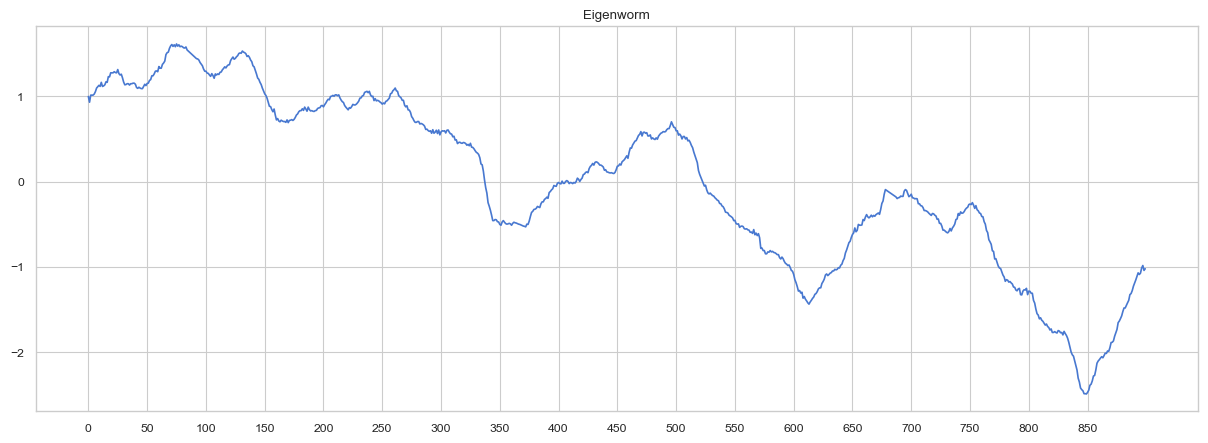

In [27]:
# plot the eigenworm
plt.figure(figsize=(15,5))
plt.plot(range(0, 900), X)
plt.xticks(range(0, 900, 50))
plt.title("Eigenworm")
plt.show()

A first visual inspection of the time series reveals that it does not seem to be stationary.
There is a clear downward trend. As this seems to be linear, we detrend the time series, using SciPy's signal function to be able to see other underlying patterns better.

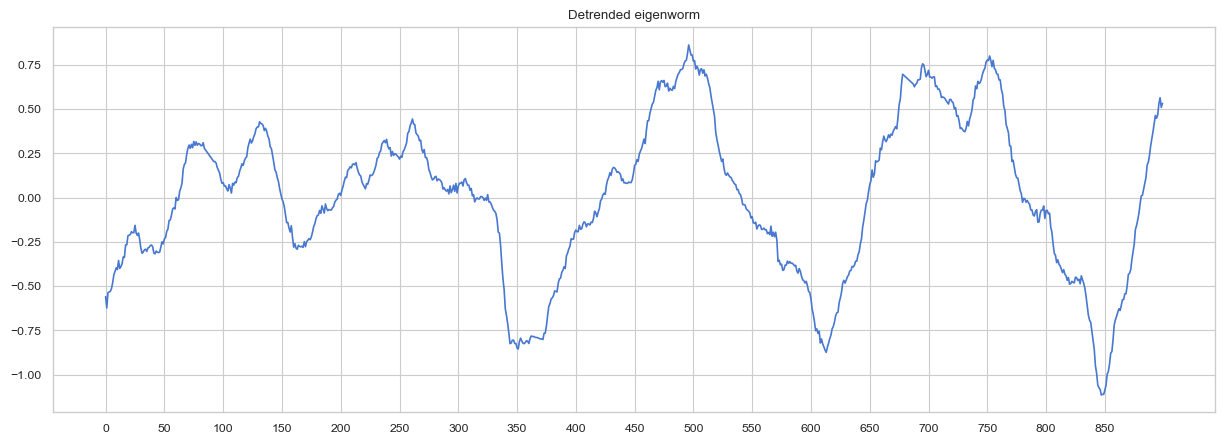

In [28]:
# detrend time series
X_detrended = signal.detrend(X, type='linear')

# plot detrended time series
plt.figure(figsize=(15,5))
plt.plot(range(0, 900), X_detrended)
plt.xticks(range(0, 900, 50))
plt.title("Detrended eigenworm")
plt.show()

The detrended graph still reveals some patterns. On the one hand, there might be seasonality but there does not seem to be a clearly regular pattern and the domain knowledge also does not suggest any obvious seasonality interval. Another thing that is obvious is that the change rates increase towards the higher ranges. But this is not necessarily problematic.

### 2. Check for stationarity
The previous visual inspection in 1 revealed that the eigenworm time series is clearly non stationary. 
Moreover, it exhibits a downward trend. As this trend is linear, we do not need to do anything as differencing to make the time-series stationary will take care of that trend.

We will check for stationarity using the Augmented Dickey-Fuller (ADF) test and visually inspecting the time series differenced at the suggested interval.
In contrast to the normal Dickey-Fuller test, this allows for differencing in the tested underlying equation. The order of the differencing is an indicator for the Autoregressive (AR) component of the time series.

Under ADF, the $H_0$ is that the time series is non-stationary and the $H_A$ is that it's stationary. To ensure stationarity, we have to be able to reject $H_0$ at a common threshold for statistical significance.

From visual inspection, the order of differencing to make the time series stationary is not immediately obvious. Therefore, we will loop through various differences and check their effect on stationarity. It is important to note that higher order differencing considerably reduces the length of the time series which can lead to problems as the amount of information decreases or if the time series is already relatively short in the first place. We will test from 1 to 10 which is already quite extensive

In [29]:
# check for stationarity in the range of 0 to 50
intervals = [i for i in range(1, 11)]

# initialize empty dataframe
df_results = pd.DataFrame(columns=["Interval", "ADF Statistic", "p-value", "1%", "5%", "10%"])

for i in intervals:
  X_difference = difference(X_detrended, i)
  result = adfuller(X_difference)
  df_results.loc[len(df_results)] = [i, result[0], result[1], result[4]["1%"], result[4]["5%"], result[4]["10%"]]

df_results

,Interval,ADF Statistic,p-value,1%,5%,10%
0,1.0,-6.458526,1.462820e-08,-3.437711,-2.864789,-2.568500
1,2.0,-5.031073,1.925603e-05,-3.437820,-2.864837,-2.568526
2,3.0,-4.473523,2.194746e-04,-3.437846,-2.864849,-2.568532
3,4.0,-4.420756,2.727081e-04,-3.437846,-2.864849,-2.568532
4,5.0,-4.348664,3.654824e-04,-3.437854,-2.864853,-2.568534
5,6.0,-4.244223,5.540857e-04,-3.437846,-2.864849,-2.568532
6,7.0,-3.493503,8.155532e-03,-3.437880,-2.864864,-2.568540
7,8.0,-4.374968,3.286196e-04,-3.437871,-2.864860,-2.568538
8,9.0,-3.817250,2.735672e-03,-3.437889,-2.864868,-2.568542
9,10.0,-3.319846,1.401434e-02,-3.437906,-2.864876,-2.568546


It seems that first-differencing is already sufficient to make the time series stationary. Now, let's plot the this time series.

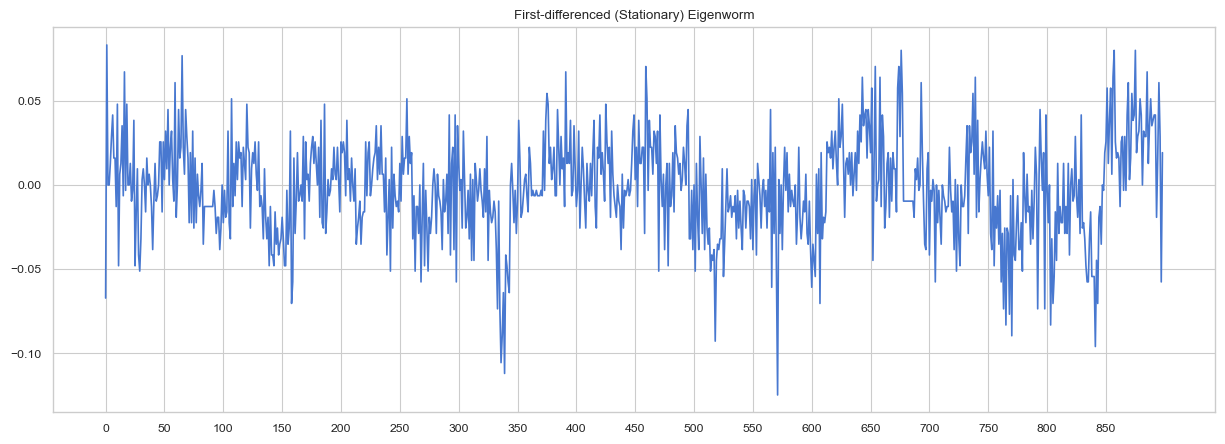

In [30]:
# take first difference
X_difference = difference(X, 1)

# plot the stationary time series
plt.figure(figsize=(15,5))
plt.plot(range(0, 899), X_difference)
plt.xticks(range(0, 900, 50))
plt.title("First-differenced (Stationary) Eigenworm")
plt.show()

As we can see the time series is now stationary and a visual inspection does not reveal any clear patterns. This already covers the *"I"* part of ARIMA as it refers to the order of differencing of the original data. In the $ARIMA(p,d,q)$ notations that means we now know that $d=1$, which leaves $p$ and $q$.

### 3. Inspect the ACF and PACF to determine the Auto-Regressive (AR) and Moving Average (MA) orders of the model
This section aims at determining the order of the AR component of the model $p$ and the MA component of the model $q$. 
Here, we follow a manual approach of visually inspecting the ACF and PACF. In sections 4 and 5, we will also perform grid-search to find the best $p$ and $q$ among a range of possible values.

Conceptually, the Auto-Correlation Function (ACF) and the Partial Auto-Correlation Function (PACF) are quite similar to each other as they both measure the correlation between a value in a time-series at time $y_t$ and $y_{t-k}$ where k is the order of the lag, also called auto-correlation.
They differ in the fact that the ACF does not control for any other lags so that the detected auto-correlation can be influenced by lags, other than $y_{t-k}$. In the PACF, we control for all intermediate lags and through this, detangling $y_{t-k}$'s direct effect on $y_t$. In practice, they can be used to determine the order of the AR component (using PACF) and the MA component (using ACF). 

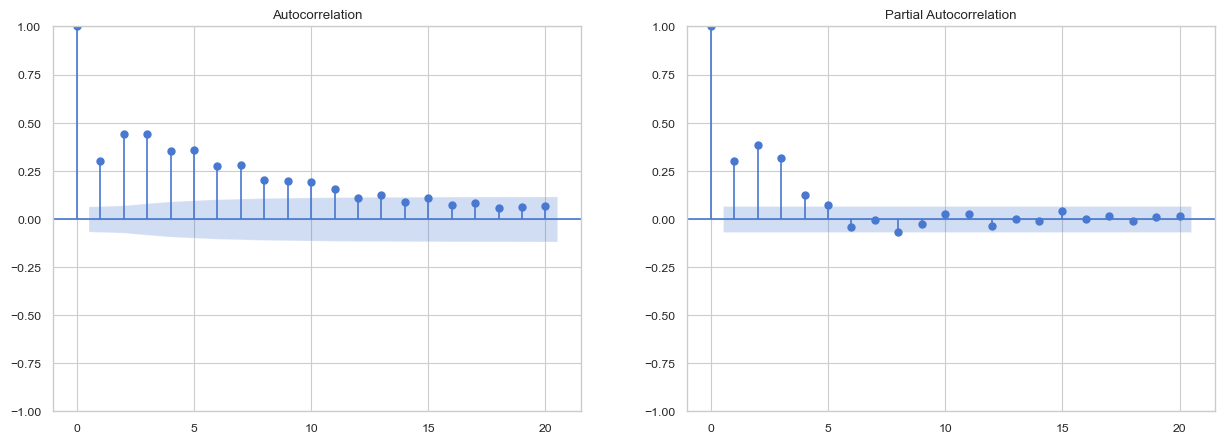

In [31]:
# plot ACF and PACF of the stationary time series in one figure with subplots
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_acf(X_difference, ax=plt.gca(), lags=20)
plt.subplot(1,2,2)
plot_pacf(X_difference, ax=plt.gca(), lags=20)
plt.show()

Both the ACF and the PACF show significant autocorrelations to relatively high degrees. For both, the first lag is slightly lower than the second. We have to keep this fact in mind as it might suggest a mix of an $AR(p)$ and an $MA(q)$ process. 
For now, we observe that the autocorrelations (in the ACF) slowly decrease as the lags increase. This could be considered a "geometric decay".
The partial autocorrelations show a sharp drop after the third lag.

If the described pattern in the ACF would already start with the first lag that would strongly suggest working with an AR only process. But as previously mentioned the fact that the first lag is less strong than the following lags in both the ACF and PACF is important and hints at using a combination of AR and MA. We decide to use an ARIMA(2,1,3) as a manually configured model as the PACF starts to decay starting at lag 2 ($p=2$) and the ACF starts to decay after lag 3 ($q=3$).
In the following, we use the same CV procedure as above to arrive at an ARIMA model to ensure comparability. We will work with the non-stationary time-series and do the first differencing within the ARIMA model ($d=1$).

### 4. ARIMA modelling (walk-forward validation)
In this section, we will estimate an ARIMA model, using simple walk-forward validation. We will both estimate the model, using $p$ and $q$ as derived above and do a grid-search, trying different configurations. We will keep $d=1$ in all instances.

#### 4.1. Naive forecast
To check predictive performance of our model, we have to establish a baseline to compare it to. Usually, this entails creating a simple model which is also called naive forecast or persistence. This can then be used to compare how much better our found model is. For this naive forecast we will use a special case of the rolling CV as explained in the second lecture, a walk-forward validation. It entails adding exactly one new datapoint from the test set to the train set for each iteration.
In this naive forecast the prediction for $X_t$ is simply $X_{t-1}$.

In [32]:
# define initial training set at 50% of the data, it will increase over time on a rolling basis
train_size = int(len(X) * 0.50)
X_train, X_test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in X_train]
predictions = list()
for i in range(len(X_test)):
  # predict y as last value
  y_pred = history[-1]
  predictions.append(y_pred)

  # add new observation to history/ train set
  history.append(X_test[i])

# calculate RMSE to check performance of the naive forecast
rmse = mean_squared_error(X_test, predictions, squared=False)
print(f"Naive Forecast RMSE: {rmse}")

Naive Forecast RMSE: 0.03223179653286934


With 0.0322, the RMSE is relatively low. To put it into context of our time series which is normalized, we can see that the forecast is on average 3.22% of a standard deviation off. Next, we plot this naive forecast for visual interpretation.

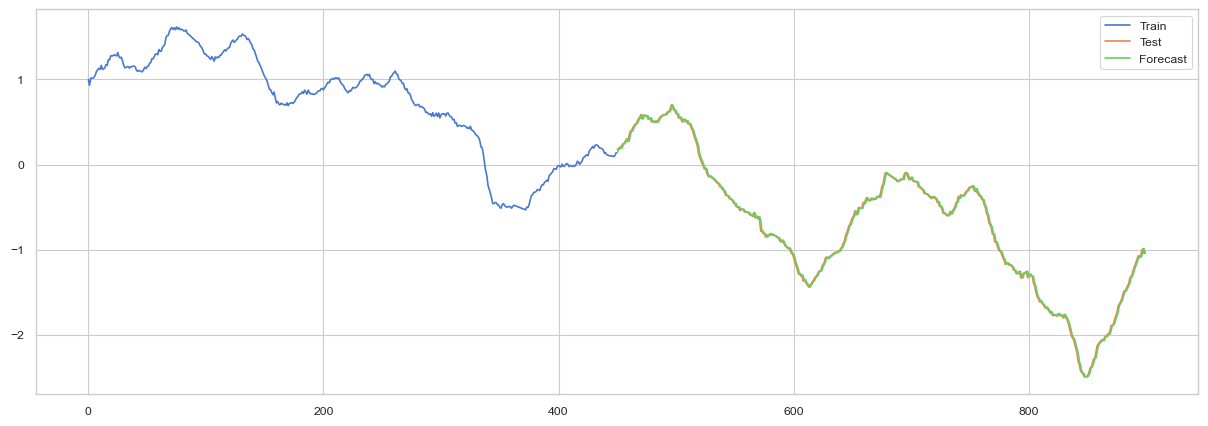

In [33]:
# plot train, test and forecast
plt.figure(figsize=(15,5))
plt.plot(X_train, label='Train')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), predictions, label='Forecast')
plt.legend(loc='best')
plt.show()

#### 4.2. ARIMA model (manual approach)
Now that we have a naive forecast as a baseline, we can proceed with developing a more complex model.

In [34]:
# ARIMA(2,1,3) model
# the data has already been prepared above

# define initial training set at 50% of the data, it will increase over time on a rolling basis
train_size = int(len(X) * 0.50)
X_train, X_test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in X_train]
predictions = list()
for i in range(len(X_test)):
  # initialize ARIMA model and fit on history
  model = ARIMA(history, order=(2,1,3))
  model_fit = model.fit(method_kwargs={'warn_convergence': False})

  # predict y and add to predictions
  y_pred = model_fit.forecast()[0]
  predictions.append(y_pred)

  # add new observation to history/ train set
  history.append(X_test[i])

# calculate RMSE to check performance of the naive forecast
rmse = mean_squared_error(X_test, predictions, squared=False)
print(f"ARIMA(2,1,3) Forecast RMSE: {rmse}")

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2,1,3) Forecast RMSE: 0.02616365213834432


We are not concerned about the convergence warnings because they only relate to quite few of the many iterations, we ignore them to make the output more readable. Also, the warnings concerning invertibility and non-stationarity only relate to problems in the packages ability to automatically find good starting values and not about the process itsel. This has been extensively discussed under this link: https://groups.google.com/g/pystatsmodels/c/S_Fo53F25Rk/m/ADO5wndkAAAJ?pli=1. Again, this warning only popped up for 2 of the many iterations so we can move on.

The following figure shows the actual eigenworm values over the entire range and the corresponding forecast for the relevant range.

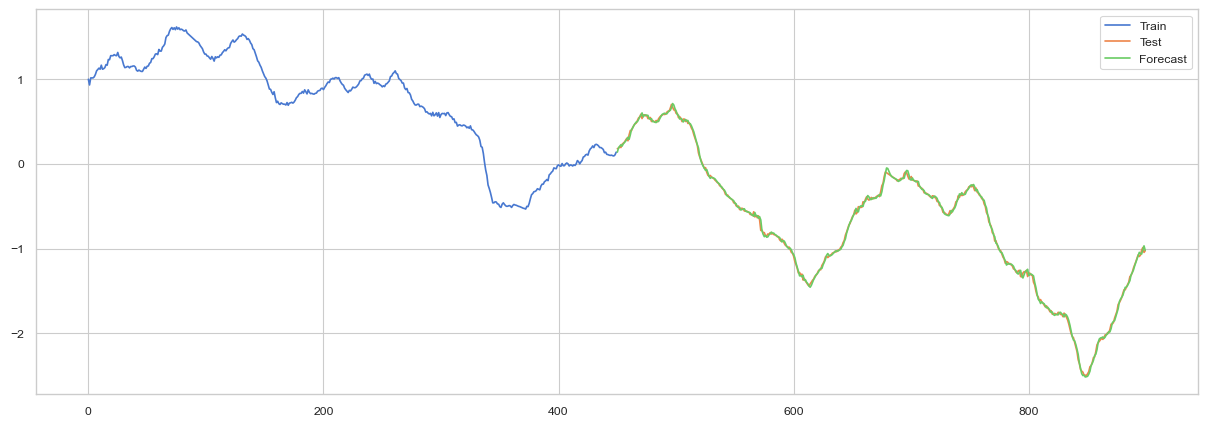

In [35]:
# plot train, test and forecast
plt.figure(figsize=(15,5))
plt.plot(X_train, label='Train')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), X_test, label='Test')
plt.plot(range(len(X_train), len(X_train) + len(X_test)), predictions, label='Forecast')
plt.legend(loc='best')
plt.show()

The following chart displays the forecast and the actual values for the last 100 time points to get a better overview of the data.

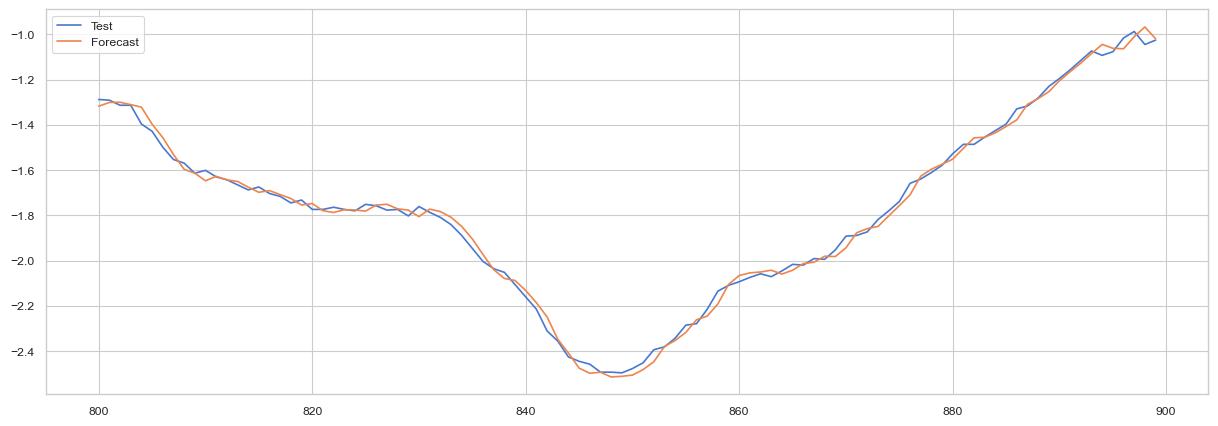

In [36]:
# plot test and forecast
plt.figure(figsize=(15,5))
plt.plot(range(800, 900), X_test[-100:], label='Test')
plt.plot(range(800, 900), predictions[-100:], label='Forecast')
plt.legend(loc='best')
plt.show()

To check whether the model is not predicting with a bias, we now check the residual plot. 

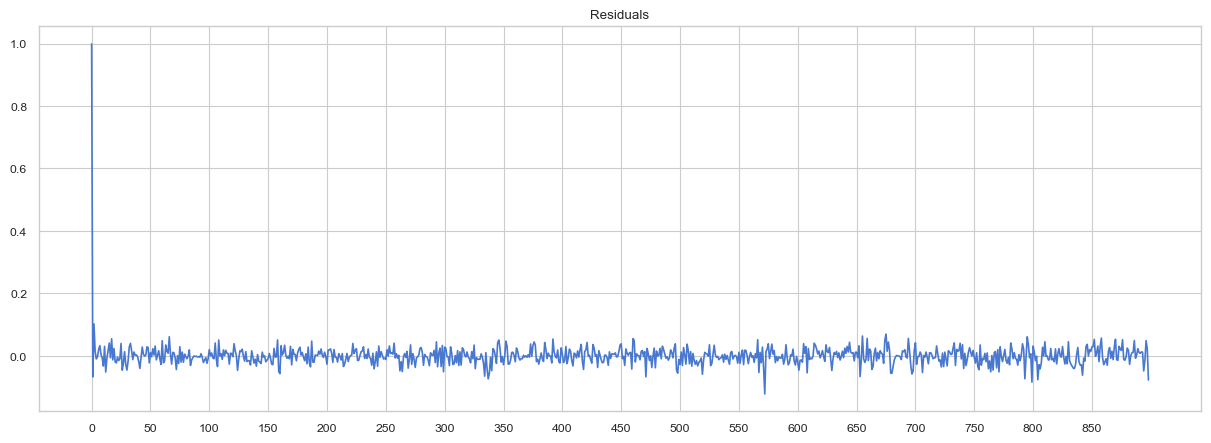

In [37]:
# retrieve the residuals of the model
residuals = pd.DataFrame(model_fit.resid)

# plot the residuals
plt.figure(figsize=(15,5))
plt.plot(range(0, 899), residuals)
plt.xticks(range(0, 900, 50))
plt.title("Residuals")
plt.show()

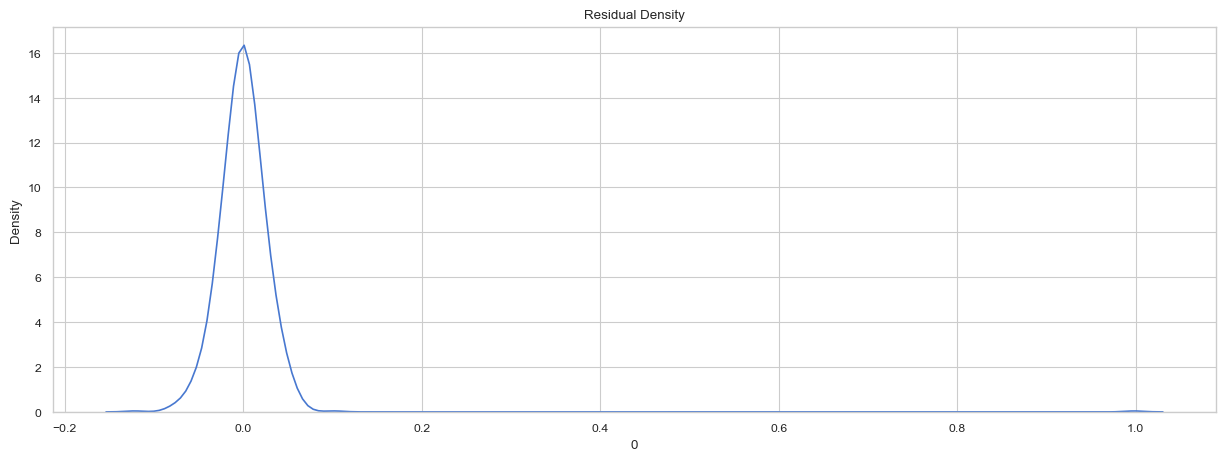

In [38]:
# plot the kde of residual density
plt.figure(figsize=(15,5))
sns.kdeplot(residuals[0])
plt.title("Residual Density")
plt.show()

We would like to have a closer look at the mean of the residuals, so we only plot close to 0.

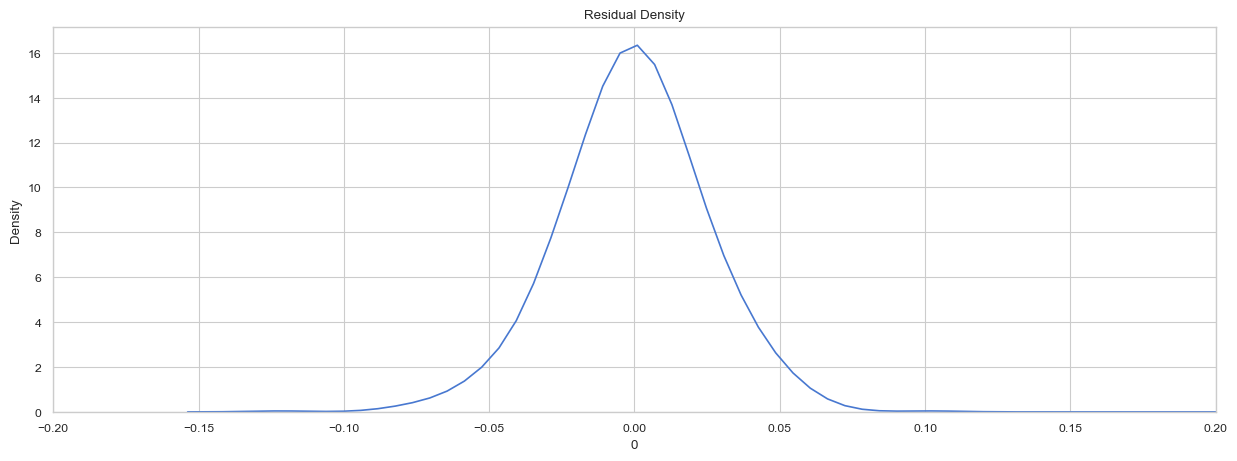

In [39]:
# plot the residual density around 0
plt.figure(figsize=(15,5))
sns.kdeplot(residuals[0])
plt.xlim(-0.2, 0.2)
plt.title("Residual Density")
plt.show()

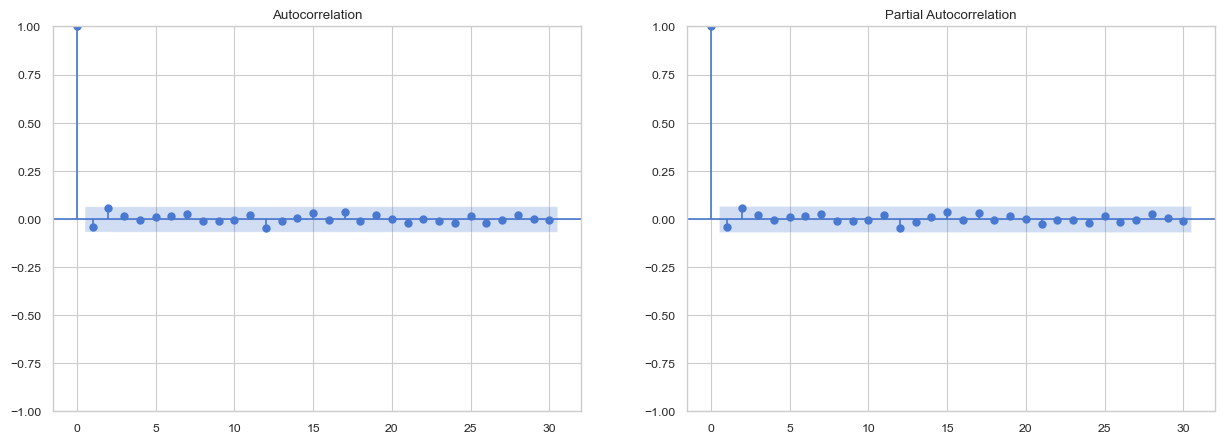

In [40]:
# plot ACF and PACF of the residuals in one figure with subplots
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_acf(residuals, ax=plt.gca(), lags=30)
plt.subplot(1,2,2)
plot_pacf(residuals, ax=plt.gca(), lags=30)
plt.show()

The graphs above reveal that the residuals of the model are fine. 
1. The residual plot shows that they are white noise.
2. The residual density function shows that they have a mean of zero, meaning that they do not have a bias to constantly predict lower or higher values.
3. The residuals show no degree of auto-correlation.

The manual process for estimating an ARIMA model reveals that a combination of an AR(2) and an MA(3) process with first-order differencing seems to do a good job at predicting the time series at hand. Given that this is still a fairly easy model and that we were able to improve the RMSE from the Naive Forecast by 18.6% from 0.0322 to 0.0262, we could use this process to model the series and use it for forecasting.

#### 4.2. ARIMA model (grid-search approach)

In [41]:
# implement grid-search

# make lists of p and q
ps = [x for x in range(0, 6)]
qs = [x for x in range(0, 6)]

# set difference to 1
d = 1

# initialize empty dataframe
df_results = pd.DataFrame(columns=["p", "d", "q", "RMSE"])

# loop over p and q
for p in ps:
    for q in qs:
        # set initial train and test set
        train_size = int(len(X) * 0.50)
        X_train, X_test = X[0:train_size], X[train_size:]

        # walk-forward validation
        history = [x for x in X_train]
        predictions = list()

        # run model
        for i in range(len(X_test)):
            # initialize ARIMA model and fit on history
            model = ARIMA(history, order=(p,d,q))
            model_fit = model.fit(method_kwargs={'warn_convergence': False})

            # predict y and add to predictions
            y_pred = model_fit.forecast()[0]
            predictions.append(y_pred)

            # add new observation to history/ train set
            history.append(X_test[i])

        # calculate RMSE of this model
        rmse = mean_squared_error(X_test, predictions, squared=False)  

        # add results to dataframe
        df_results.loc[len(df_results)] = [p, d, q, rmse]

# print results
df_results.sort_values(by="RMSE", ascending=True, inplace=True)
display(df_results)

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

,p,d,q,RMSE
19,2.0,1.0,3.0,0.026164
27,3.0,1.0,3.0,0.026178
35,4.0,1.0,3.0,0.026178
20,2.0,1.0,4.0,0.026188
43,5.0,1.0,3.0,0.026189
37,4.0,1.0,5.0,0.026197
40,5.0,1.0,0.0,0.026219
41,5.0,1.0,1.0,0.026220
10,1.0,1.0,2.0,0.026229
21,2.0,1.0,5.0,0.026233


Nicely, the grid-search reveals that the manual selection procedure made sense and that we detected the right underlying process. However, the grid-search also shows that the performance of the model is quite similar using a slightly higher order in one of the model components (AR and MA).

### 5. Blocked CV
For comparing the different models, using the above walk-forward validation seems fine because all models use the same validation procedure. However, to ensure that our model is indeed the best for the entire data range, we also implement a blocked CV which prevents data leakage and also incorporates test sets of the first 50% of the time series. The blocked CV approach, we use is an adaption of the procedure introduced in class as we use walk-forward validation within each fold. This should increase robustness of results.

This section is structured identically as the one above.

#### 5.1. Naive forecast

In [42]:
# number of folds
n_folds = 10
fold_size = int(len(X) / n_folds)

# RMSE store
rmse_scores = []

for fold in range(n_folds):
    # fold data
    fold_data = X[fold * fold_size : (fold + 1) * fold_size if fold < n_folds - 1 else len(X)]

    # 50/50 split on fold data
    split_index = int(len(fold_data) * 0.50)
    X_train, X_test = fold_data[:split_index], fold_data[split_index:]

    # Walk-forward validation for the current fold
    history = list(X_train)
    predictions = []
    for i in range(len(X_test)):
        # naive forecast
        y_pred = history[-1]
        predictions.append(y_pred)

        # update history
        history.append(X_test[i])

    # RMSE for the current fold
    rmse = mean_squared_error(X_test, predictions, squared=False)
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} Naive Forecast RMSE: {rmse}")

# average RMSE and variance across all folds
average_rmse = sum(rmse_scores) / n_folds
variance = sum([((x - average_rmse) ** 2) for x in rmse_scores]) / n_folds

print(f"Average Naive Forecast RMSE across all folds: {average_rmse}")
print(f"Variance in Naive Forecast RMSE across all folds: {variance}")

Fold 1 Naive Forecast RMSE: 0.025659168139100075
Fold 2 Naive Forecast RMSE: 0.030232107266783714
Fold 3 Naive Forecast RMSE: 0.023712705820798874
Fold 4 Naive Forecast RMSE: 0.03920372575521469
Fold 5 Naive Forecast RMSE: 0.019349602982401848
Fold 6 Naive Forecast RMSE: 0.03267700970172882
Fold 7 Naive Forecast RMSE: 0.02899307943880558
Fold 8 Naive Forecast RMSE: 0.026878617703914642
Fold 9 Naive Forecast RMSE: 0.03983607515692711
Fold 10 Naive Forecast RMSE: 0.03911380097270012
Average Naive Forecast RMSE across all folds: 0.03056558929383755
Variance in Naive Forecast RMSE across all folds: 4.51100415101073e-05


The output of the 10-fold blocked CV with walk-forward validation in each fold, shows that the performance of the forecast can differ quite substantially, depending on the region of the time-series. It ranges from the lowest RMSE in fold 5 of 0.0193 to the largest RMSE in fold 9 of 0.0398. The average RMSE across all folds is 0.0306 which is lower than the RMSE of the naive forecast in section 4, using only walk-forward validation.

#### 5.2. ARIMA model (manual approach)

In [43]:
# number of folds
n_folds = 10
fold_size = int(len(X) / n_folds)

# RMSE store
rmse_scores = []

for fold in range(n_folds):
    # fold data
    fold_data = X[fold * fold_size : (fold + 1) * fold_size if fold < n_folds - 1 else len(X)]

    # 50/50 split on fold data
    split_index = int(len(fold_data) * 0.50)
    X_train, X_test = fold_data[:split_index], fold_data[split_index:]

    # Walk-forward validation for the current fold
    history = list(X_train)
    predictions = []
    for i in range(len(X_test)):
        # Initialize and fit ARIMA model
        model = ARIMA(history, order=(2,1,3))
        model_fit = model.fit(method_kwargs={'warn_convergence': False})

        # predict
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)

        # update history
        history.append(X_test[i])

    # Calculate RMSE 
    rmse = mean_squared_error(X_test, predictions, squared=False)
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# average RMSE and variance across all folds
average_rmse = sum(rmse_scores) / n_folds
variance = sum([((x - average_rmse) ** 2) for x in rmse_scores]) / n_folds

print(f"Average ARIMA(2,1,3) Forecast RMSE across all folds: {average_rmse}")
print(f"Variance in ARIM(2,1,3) Forecast RMSE across all folds: {variance}")

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 1 RMSE: 0.021698967309364457
Fold 2 RMSE: 0.022541219746486894


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fold 3 RMSE: 0.021563506863203966


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fold 4 RMSE: 0.03185292953945711
Fold 5 RMSE: 0.019651702993714985


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 6 RMSE: 0.025882175139929298
Fold 7 RMSE: 0.025348048271515322
Fold 8 RMSE: 0.028559846448741197


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 9 RMSE: 0.03379896599080048


/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 10 RMSE: 0.028674389492232676
Average Naive Forecast RMSE across all folds: 0.02595717517954464
Variance in Naive Forecast RMSE across all folds: 1.996518010991175e-05


As expected, the ARIMA model also performs better than the naive forecast when using another cross-validation approach. It is both better in terms of average RMSE and in the variance of RMSE across folds. This shows that the ARIMA model is indeed better in modeling the time series than the naive forecast. The average RMSE improves by 15% from 0.0306 to 0.026.

#### 5.3. ARIMA model (grid-search approach)

In [45]:
# make lists of p and q
ps = [x for x in range(0, 6)]
qs = [x for x in range(0, 6)]

# set difference to 1
d = 1

# initialize empty dataframe
df_results = pd.DataFrame(columns=["p", "d", "q", "Average RMSE", "Variance of RMSE"])

# loop over p and q
for p in ps:
    for q in qs:
        # number of folds
        n_folds = 10
        fold_size = int(len(X) / n_folds)

        # RMSE store
        rmse_scores = []

        for fold in range(n_folds):
            # fold data
            fold_data = X[fold * fold_size : (fold + 1) * fold_size if fold < n_folds - 1 else len(X)]

            # 50/50 split on fold data
            split_index = int(len(fold_data) * 0.50)
            X_train, X_test = fold_data[:split_index], fold_data[split_index:]

            # Walk-forward validation for the current fold
            history = list(X_train)
            predictions = []
            for i in range(len(X_test)):
                # Initialize and fit ARIMA model
                model = ARIMA(history, order=(p, d, q))
                model_fit = model.fit(method_kwargs={'warn_convergence': False})

                # predict
                y_pred = model_fit.forecast()[0]
                predictions.append(y_pred)

                # update history
                history.append(X_test[i])

            # Calculate RMSE for each fold and store
            rmse = mean_squared_error(X_test, predictions, squared=False)
            rmse_scores.append(rmse)

        # average RMSE and variance across all folds
        average_rmse = sum(rmse_scores) / n_folds
        variance = sum([((x - average_rmse) ** 2) for x in rmse_scores]) / n_folds

        # add results to dataframe
        df_results.loc[len(df_results)] = [p, d, q, average_rmse, variance]

# sort and display results
df_results.sort_values(by="Average RMSE", ascending=True, inplace=True)
display(df_results)

/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tildietrich/venvs/data_science_py/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters

,p,d,q,Average RMSE,Variance of RMSE
18,3.0,1.0,0.0,0.025294,0.000016
24,4.0,1.0,0.0,0.025422,0.000019
13,2.0,1.0,1.0,0.025459,0.000017
19,3.0,1.0,1.0,0.025478,0.000019
25,4.0,1.0,1.0,0.025585,0.000020
14,2.0,1.0,2.0,0.025601,0.000020
8,1.0,1.0,2.0,0.025653,0.000020
31,5.0,1.0,1.0,0.025696,0.000020
26,4.0,1.0,2.0,0.025778,0.000020
30,5.0,1.0,0.0,0.025806,0.000019


Surprisingly, this cross-validation approach in combination with grid-search suggests another model than the manual approach. This proves to show that in cases where different ARIMA models perform similarly well, different validation approaches can yield different "best models". Also, we remember that the pattern in ACF and PACF was not 100% clear and was could also have been interpreted as an AR only process with $p=3$. This cross-validation procedure, considering the entire space of the time series seems to prefer that configuration.